In [27]:
import yfinance as yahooFinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

In [3]:
daily_apple = yahooFinance.download("AAPL", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_appleBefore = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
appleDiff = daily_apple['Close'].diff()
appleDiff.dropna(inplace=True)


In [5]:
daily_bitcoin.index



NameError: name 'daily_bitcoin' is not defined

In [ ]:
plt.plot(daily_bitcoin['Close'])



In [ ]:
plt.plot(daily_apple['Close'])

In [ ]:
#https://mayerkrebs.com/relative-strength-index-rsi-in-python/
#RSI
def rsi(closeArray, period=14):
    dayDiff = closeArray.diff()
    dayDiff.dropna(inplace=True)
    diffPos = dayDiff.copy()
    diffNeg = dayDiff.copy()

    diffPos[diffPos<0] = 0
    diffNeg[diffNeg>0] = 0
    avgPos = diffPos.rolling(period).mean()
    avgNeg = diffNeg.rolling(period).mean().abs()

    rsi = 100* avgPos / (avgPos + avgNeg)
    rsi.head(20)
    return rsi


In [13]:
#https://dayanand-shah.medium.com/exponential-moving-average-and-implementation-with-python-1890d1b880e6
#EMA
##def ema(closeArray, period):
  #  ema = closeArray.ewm(span=period, adjust=False).mean()
   # return ema



    #définition d'un exponential movind average sur un 1d array

def ema(closeArray, period):
    
    ema = np.zeros_like(closeArray)
    
    alpha = 2 /(period + 1)
    
    for i in range(period, len(closeArray)):
        
        if np.isnan(closeArray[i]) :
            
            continue
        
        else:
            
            ema[i] = alpha*closeArray[i] + (1 - alpha)*ema[i-1]
        
        
    ema[ema==0]=np.nan
    
    return ema


    
def PEMA(closeArray,period):
    MA1 = ema(closeArray,period)
    MA2 = ema(MA1,period)
    MA3 = ema(MA2,period)
    MA4 = ema(MA3,period)
    MA5 = ema(MA4,period)
    MA6 = ema(MA5,period)
    MA7 = ema(MA6,period)
    MA8 = ema(MA7,period)
    PEMA = 8*MA1 - 28*MA2 + 56*MA3 -70*MA4 + 56*MA5 - 28*MA6 + 8*MA7 - MA8
    return PEMA



    

In [6]:
appleRSI = rsi(daily_apple['Close'])

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(appleRSI, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')


NameError: name 'rsi' is not defined

In [7]:
applePEMA = PEMA(daily_appleBefore['Close'].to_numpy(), 34)

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the EMA
ax2.set_title('PEMA')
applePEMADate =  applePEMA[len(applePEMA) - len(daily_apple.index):]
ax2.plot(daily_apple.index, applePEMADate, color='green', linewidth=1)
ax2.plot(daily_apple.index, daily_apple['Close'], color='blue', linewidth=1)

NameError: name 'PEMA' is not defined

In [8]:
def pemaSignals(pema):
    deltaPEMA = np.diff(pema)
    
    buySignal = np.zeros_like(deltaPEMA)
    sellSignal = np.zeros_like(deltaPEMA)
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] < 0. and deltaPEMA[i] > 0. :
                buySignal[i] = 1
            else:
                   buySignal[i] = np.nan
        else:
            buySignal[i] = np.nan
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] > 0. and deltaPEMA[i] < 0. :
                sellSignal[i] = 1
            else:
                   sellSignal[i] = np.nan
        else:
            sellSignal[i] = np.nan
        
    buySignal[len(buySignal)-1] = np.nan
    sellSignal[len(buySignal)-1] = np.nan

    return buySignal, sellSignal


In [36]:
def moneyMade(buySignals, sellSignals, stockPrices, titre, showBuyHold):
    cashAmount = 0
    hasInvested = False
    initialBoughtAction = 0
    stockAmount = 1.
    
    for i in range(len(stockPrices)):
        if not hasInvested:
            if(buySignals[i] == 1):
                hasInvested = True
                initialBoughtAction = stockPrices.iloc[i]
                cashAmount = initialBoughtAction
        
        else:   
            if(buySignals[i] == 1):
                stockAmount = cashAmount/stockPrices.iloc[i]

            if(sellSignals[i] == 1):
                cashAmount = stockAmount*stockPrices.iloc[i]
    
    profit = 100*(cashAmount / initialBoughtAction - 1)
    buyHold = 100*(stockPrices.iloc[i-1]/stockPrices.iloc[0] - 1)
    if(showBuyHold):
        print(titre +  ' Profit :', profit, '%')
        print('Acheter action Profit: ', buyHold, '%')
    return profit
    

In [33]:

def pemaResult(daily, dailyBefore, pemaPeriod, titre, showPlot):
    dailyPemaLong = PEMA(dailyBefore['Close'].to_numpy(), pemaPeriod)
    dailyPema = dailyPemaLong[(len(dailyPemaLong)-1) - len(daily.index):]

    
    #diffPEMA = np.append(np.diff(dailyPema), 0)
    buySignal, sellSignal = pemaSignals(dailyPema)

    if(showPlot):
        dailyPema = dailyPema[0:-1]
        fig, ax = plt.subplots(figsize=(11, 6))
        priceArray = daily['Close'].to_numpy()
        lowest_point = np.min(priceArray)
        max_point = np.max(priceArray)
        ax.plot(daily.index, buySignal*daily['Close'], '*g')
        ax.plot(daily.index, sellSignal*daily['Close'], '*r')
        ax.plot(daily.index, dailyPema, color='purple', linewidth=1)
        ax.plot(daily.index, daily['Close'])
        plt.title(titre)
        ax.autoscale_view()
        fig.autofmt_xdate()
        
       # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA >= 0, facecolor = 'green', alpha = .2)
       # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA < 0, facecolor = 'red', alpha = .2)
    
        buySignalPd = pd.Series(list(buySignal), index=list(range(0,len(daily.index))))
        sellSignalPd = pd.Series(list(sellSignal), index=list(range(0,len(daily.index))))
    
        begi = 0
        for i in range(len(daily.index)):
            if(begi == 0):
                if(buySignal[i]==1):
                    ax.fill_between(daily.index[0:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                    begi = i
            else:
                if(sellSignal[i] == 1):
                    ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                    begi = i
                    
                if(buySignal[i] ==1):
                    ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'red', alpha = .2)
                    begi = i

    
    profit = moneyMade(buySignal, sellSignal, daily['Close'], titre, showPlot)
    return profit


In [34]:

def backTest(daily, dailyBefore, string, freq = ' jours'):
    coefficient = 0;   
    profitMax = -9999.;
    for i in range(2,40):
        message = string + str(i) + freq
        profit = pemaResult(daily, dailyBefore, i, message, False)
        if(profit > profitMax):
            profitMax = profit
            coefficient = i
    print(string + ' profit max: ' + str(profitMax) + ' avec période de '+ str(coefficient))
    return coefficient, profitMax

In [ ]:


#Apple
hourly_apple = yahooFinance.download("AAPL", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_appleBefore = yahooFinance.download("AAPL", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_apple = yahooFinance.download("AAPL", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_apple3mois = yahooFinance.download("AAPL", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_appleBefore = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_apple, daily_appleBefore, 'Apple PEMA 1 an période ')
backTest(daily_apple3mois, daily_appleBefore, 'Apple PEMA 3 mois période ')
backTest(hourly_apple, hourly_appleBefore, 'Apple PEMA 1 mois période ', ' heures')

pemaResult(daily_apple, daily_appleBefore, 18, 'Signaux PEMA Apple août 2023 - juin 2024 (Période = 18)', True)


#BNO
hourly_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_banqueNationale3mois = yahooFinance.download("NA.TO", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_banqueNationale, daily_banqueNationaleBefore, 'Banque Nationale PEMA 1 an période ')
backTest(daily_banqueNationale3mois, daily_banqueNationaleBefore, 'Banque Nationale PEMA 3 mois période ')
backTest(hourly_banqueNationale, hourly_banqueNationaleBefore, 'Banque Nationale PEMA 1 mois période ', ' heures')

pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 20, 'Signaux PEMA Banque Nationale août 2023 - juin 2024 (Période = 20)', True)



#FOREX CA-USD
hourly_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_cadusd3mois = yahooFinance.download("CADUSD=X", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_cadusd, daily_cadusdBefore, 'CAD-USD PEMA 1 an période ')
backTest(daily_cadusd3mois, daily_cadusdBefore, 'CAD-USD PEMA 3 mois période ')
backTest(hourly_cadusd, hourly_cadusdBefore, 'CAD-USD PEMA 1 mois période ', ' heures')

pemaResult(daily_cadusd, daily_cadusdBefore, 5, 'Signaux PEMA CA-USD août 2023 - juin 2024 (Période = 5)', True)



#SP500
hourly_sp500 = yahooFinance.download("^GSPC", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_sp500Before = yahooFinance.download("^GSPC", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_sp500 = yahooFinance.download("^GSPC", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_sp5003mois = yahooFinance.download("^GSPC", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_sp500, daily_sp500Before, 'SP500 PEMA 1 an période ')
backTest(daily_sp5003mois, daily_sp500Before, 'SP500 PEMA 3 mois période ')
backTest(hourly_sp500, hourly_sp500Before, 'SP500 PEMA 1 mois période ', ' heures')

pemaResult(daily_sp500, daily_sp500Before, 28, 'Signaux PEMA SP500 août 2023 - juin 2024 (Période = 28)', True)


#ubi
hourly_ubi = yahooFinance.download("UBI.PA", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_ubi = yahooFinance.download("UBI.PA", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_ubi3mois = yahooFinance.download("UBI.PA", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_ubi, daily_ubiBefore, 'Ubisoft PEMA 1 an période ')
backTest(daily_ubi3mois, daily_ubiBefore, 'Ubisoft PEMA 3 mois période ')
backTest(hourly_ubi, hourly_ubiBefore, 'Ubisoft PEMA 1 mois période ', ' heures')


pemaResult(daily_ubi, daily_ubiBefore, 10, 'Signaux PEMA Ubisoft août 2023 - juin 2024 (Période = 10)', True)




In [ ]:
#Apple
portfolioApple = yahooFinance.download("AAPL", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioAppleBefore = yahooFinance.download("AAPL", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')

pemaResult(portfolioApple, portfolioAppleBefore, 18, 'Signaux PEMA Apple août-novembre 2024 (Période = 18)', True)
backTest(portfolioApple, portfolioAppleBefore, 'Apple PEMA 3 mois période ')


#BNO
portfolioBNO = yahooFinance.download("NA.TO", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioBNOBefore = yahooFinance.download("NA.TO", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioBNO, portfolioBNOBefore, 20, 'Signaux PEMA Banque Nationale août-novembre 2024 (Période = 20)', True)


#FOREX CA-USD
portfolioCAUSD = yahooFinance.download("CADUSD=X", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioCAUSDBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioCAUSD, portfolioCAUSDBefore, 5, 'Signaux PEMA CA-USD août-novembre 2024 (Période = 5)', True)


#SP500
portfolioSP500 = yahooFinance.download("^GSPC", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolio_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioSP500, portfolio_sp500Before, 28, 'Signaux PEMA SP500 août-novembre 2024 (Période = 28)', True)

#ubi
portfolioUbi = yahooFinance.download("UBI.PA", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolio_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioUbi, portfolio_ubiBefore, 10, 'Signaux PEMA Ubisoft août-novembre 2024 (Période = 10)', True)



In [ ]:


def determineCoefficient(ticker, firstDate, iterations):

    
    startDate = firstDate
    for i in range(iterations):
        if(i>0):
            startDate = startDate + relativedelta(months=1)
        endDate = startDate + relativedelta(months=3)
        daily = yahooFinance.download(ticker, start = startDate, end = endDate, interval = '1d')
        daily_Before = yahooFinance.download(ticker, start = datetime(2023,1,1), end = endDate, interval = '1d')
        
        message = ticker + ' de ' + str(startDate) + ' à ' + str(endDate) + ' '
        backTest(daily, daily_Before, message)
    return


#Apple

determineCoefficient("AAPL", datetime(2023,8,1), 11) 
#BNO
determineCoefficient("NA.TO", datetime(2023,8,1), 11) 
determineCoefficient("CADUSD=X", datetime(2023,8,1), 11) 
determineCoefficient("^GSPC", datetime(2023,8,1), 11) 
determineCoefficient("UBI.PA", datetime(2023,8,1), 11) 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Signaux PEMA Apple avril24-juil24 (Période = 18) Profit : 12.751051295880833 %
Acheter action Profit:  25.918959972129805 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Signaux PEMA Banque Nationale nov23-fev24 2024 (Période = 9) Profit : 13.435509776658305 %
Acheter action Profit:  19.514447691812677 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Signaux PEMA CA-USD oct23-jan24 (Période = 5) Profit : 3.424258480584319 %
Acheter action Profit:  2.8154892076028615 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Signaux PEMA SP500 oct23-jan24 (Période = 30) Profit : 10.570600240978244 %
Acheter action Profit:  11.541859419446787 %
Signaux PEMA Ubisoft fev24-mai24 (Période = 23) Profit : 27.008347307842516 %
Acheter action Profit:  9.45077605781881 %


27.008347307842516

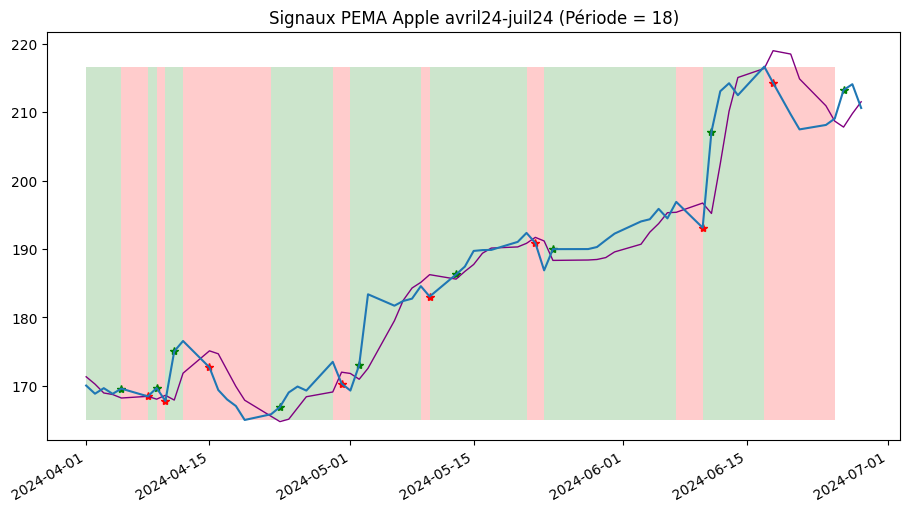

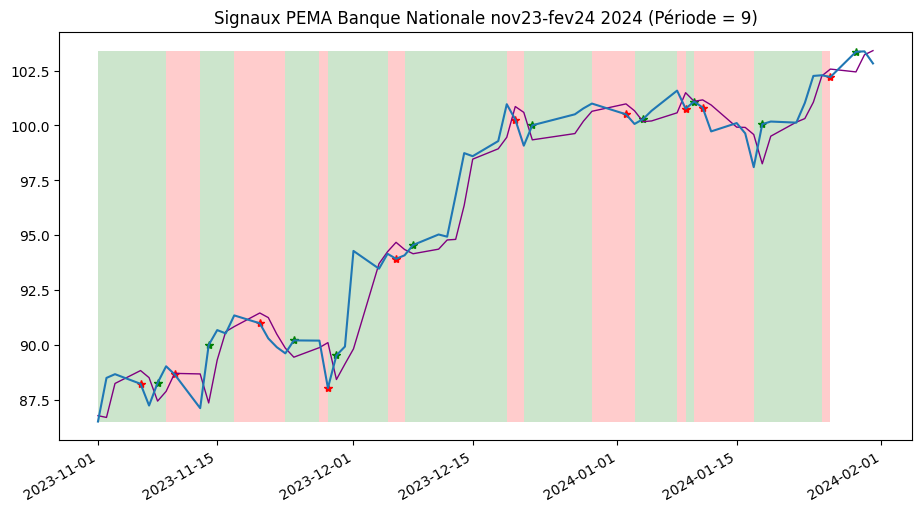

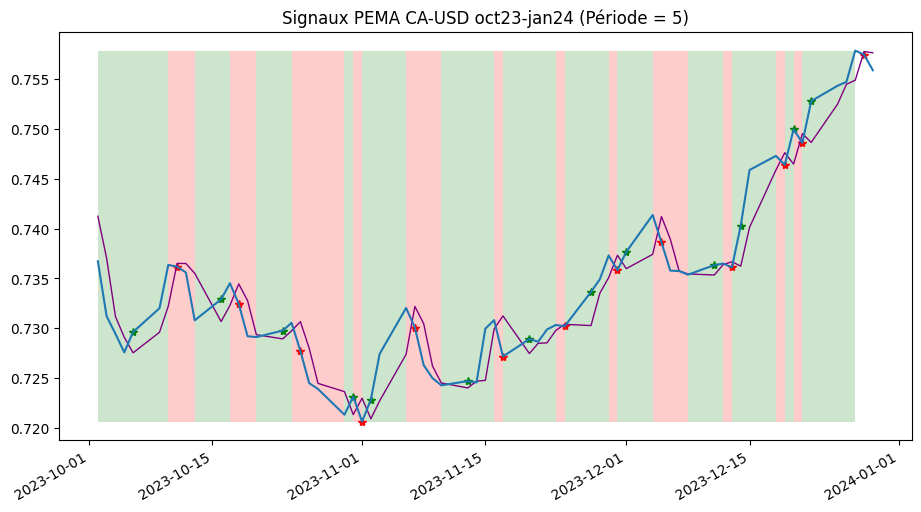

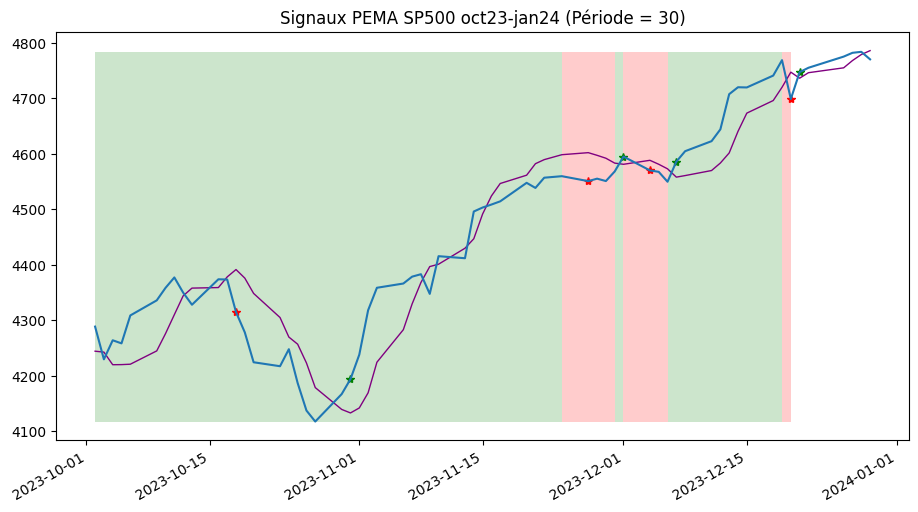

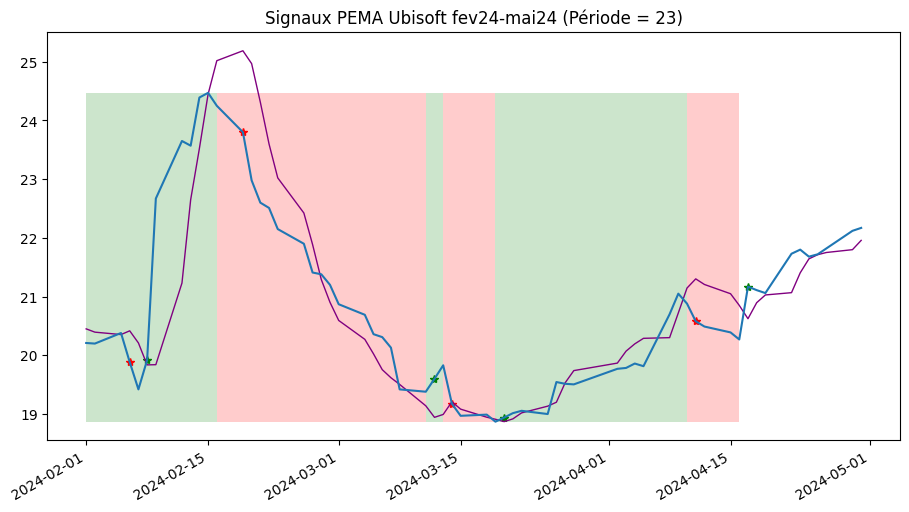

In [38]:
#Apple
portfolioApple = yahooFinance.download("AAPL", start = datetime(2024,4,1), end = datetime(2024,7,1), interval = '1d')
portfolioAppleBefore = yahooFinance.download("AAPL", start = datetime(2023,3,1), end = datetime(2024,7,1), interval = '1d')

pemaResult(portfolioApple, portfolioAppleBefore, 18, 'Signaux PEMA Apple avril24-juil24 (Période = 18)', True)


#BNO
portfolioBNO = yahooFinance.download("NA.TO", start = datetime(2023,11,1), end = datetime(2024,2,1), interval = '1d')
portfolioBNOBefore = yahooFinance.download("NA.TO", start = datetime(2023,3,1), end = datetime(2024,2,1), interval = '1d')
pemaResult(portfolioBNO, portfolioBNOBefore, 9, 'Signaux PEMA Banque Nationale nov23-fev24 2024 (Période = 9)', True)


#FOREX CA-USD
portfolioCAUSD = yahooFinance.download("CADUSD=X", start = datetime(2023,10,1), end = datetime(2024,1,1), interval = '1d')
portfolioCAUSDBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,3,1), end = datetime(2024,1,1), interval = '1d')
pemaResult(portfolioCAUSD, portfolioCAUSDBefore, 5, 'Signaux PEMA CA-USD oct23-jan24 (Période = 5)', True)


#SP500
portfolioSP500 = yahooFinance.download("^GSPC", start = datetime(2023,10,1), end = datetime(2024,1,1), interval = '1d')
portfolio_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,3,1), end = datetime(2024,1,1), interval = '1d')
pemaResult(portfolioSP500, portfolio_sp500Before, 30, 'Signaux PEMA SP500 oct23-jan24 (Période = 30)', True)

#ubi
portfolioUbi = yahooFinance.download("UBI.PA", start = datetime(2024,2,1), end = datetime(2024,5,1), interval = '1d')
portfolio_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2023,3,1), end = datetime(2024,5,1), interval = '1d')
pemaResult(portfolioUbi, portfolio_ubiBefore, 23, 'Signaux PEMA Ubisoft fev24-mai24 (Période = 23)', True)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Signaux PEMA Apple août-novembre 2024 (Période = 16) Profit : -1.350903379088808 %
Acheter action Profit:  5.376445072517333 %
Apple PEMA 3 mois période  profit max: 11.128722960009263 avec période de 4
Signaux PEMA Banque Nationale août-novembre 2024 (Période = 11) Profit : 1.923431159125255 %
Acheter action Profit:  16.508980812612318 %
BNO PEMA 3 mois période  profit max: 10.929656323061732 avec période de 23


(23, 10.929656323061732)

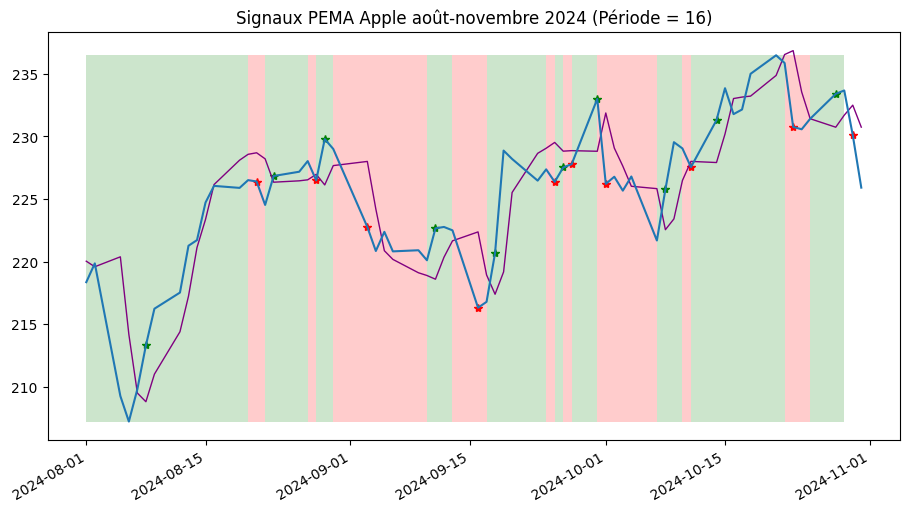

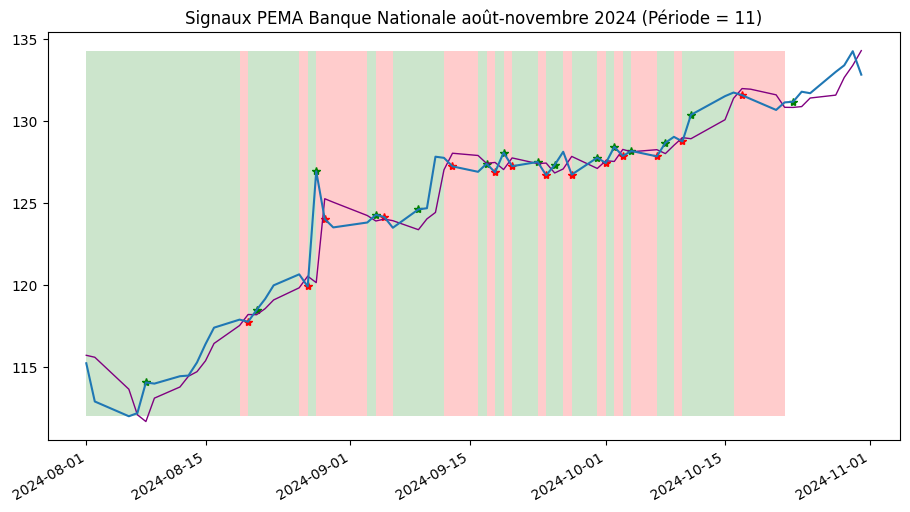

In [42]:
#Apple
portfolioApple = yahooFinance.download("AAPL", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioAppleBefore = yahooFinance.download("AAPL", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')

pemaResult(portfolioApple, portfolioAppleBefore, 16, 'Signaux PEMA Apple août-novembre 2024 (Période = 16)', True)
backTest(portfolioApple, portfolioAppleBefore, 'Apple PEMA 3 mois période ')


#BNO
portfolioBNO = yahooFinance.download("NA.TO", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioBNOBefore = yahooFinance.download("NA.TO", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioBNO, portfolioBNOBefore, 11, 'Signaux PEMA Banque Nationale août-novembre 2024 (Période = 11)', True)
backTest(portfolioBNO, portfolioBNOBefore, 'BNO PEMA 3 mois période ')
